Import libraries

In [1]:
import pandas as pd
import numpy as np
import re
from pyvi.ViTokenizer import ViTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU,  Input
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers.legacy import Adam

Load data

In [2]:
import pandas as pd 
import numpy as np 

TRAIN_DATA = '../data/ViCTSD/ViCTSD_train.csv'
DEV_DATA = '../data//ViCTSD/ViCTSD_valid.csv'
TEST_DATA = '../data/ViCTSD/ViCTSD_test.csv'

# read data
train_data = pd.read_csv(TRAIN_DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

train_data = train_data.dropna(subset=['Comment'])
dev_data = dev_data.dropna(subset=['Comment'])
test_data = test_data.dropna(subset=['Comment'])


print(len(train_data))
print(len(dev_data))
print(len(test_data))

7000
2000
1000


In [3]:
test_data

,Unnamed: 0,Comment,Constructiveness,Toxicity,Title,Topic
0,6252,Người ăn không hết kẻ lần chẳng ra,0,1,28 năm chịu đựng bộ ngực khổng lồ,SucKhoe
1,4684,Nhiều người cứ nghĩ đạp xe là văn minh. haizzzz,0,1,Cả trăm người đạp xe thể dục bịt kín đường,OtoXemay
2,1731,Rất văn hoá,0,0,Cô gái được bố nhắn nhủ ba từ mỗi ngày,GiaoDuc
3,4742,Đời ta ba mươi đời nó. Mua chiếc xe cũng chỉ p...,0,0,Các loại phụ kiện ôtô đại lý hay chào khách,OtoXemay
4,4521,"Tước bằng lái vĩnh viễn đi. Chạy lếu láo thật,...",1,1,Ba người thoát chết dưới bánh xe bồn,OtoXemay
...,...,...,...,...,...,...
995,3921,biệt thự nhà riêng to đùng thế kia mà chủ (hay...,0,1,Đại gia xăng dầu vừa bị bắt đứng sau hàng chục...,KinhDoanh
996,6685,"Trong cái khó ló cái khôn, người tài thật sự k...",0,0,Bác sĩ Cấp và những quyết định tiên phong tron...,SucKhoe
997,3194,Bánh trung thu sao lại phải có quả trứng muối ...,0,0,Bánh trung thu đua nhau phục vụ 'ăn bằng mắt',KinhDoanh
998,1941,Cấp 1 nói chung và lớp 1 nói riêng theo tôi có...,1,0,Đánh giá chương trình lớp 1 nặng là chưa xác đ...,GiaoDuc


Data preprocessing

In [4]:
# def load_teencode_dict(file_path):
#     teencode_dict = {}
#     with open(file_path, 'r', encoding='utf-8') as file:
#         for line in file:
#             if line.strip():  # Kiểm tra xem dòng không phải là dòng trống
#                 teencode, full_word = line.strip().split('\t')
#                 teencode_dict[teencode] = full_word
#     return teencode_dict
# # Đường dẫn tới file teencode.txt
# teencode_file = '../data/teencode.txt'

# # Tải từ điển teen code
# teencode_dict = load_teencode_dict(teencode_file)

# def replace_teencode(text, teencode_dict = teencode_dict):
#     words = text.split()
#     new_words = [teencode_dict.get(word, word) for word in words]
#     return ' '.join(new_words)

# # Đoạn text cần kiểm tra và thay thế
# text = "mih qtam cta r svtn"
# new_text = replace_teencode(text)

# print(new_text)

In [5]:
STOPWORDS = '../data/vietnamese-stopwords-dash.txt'
stopwords = []

with open(STOPWORDS, "r") as ins:
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    # remove emoji
    emoji_pattern = re.compile(
        pattern = "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0"  # Dingbats
            u"\U000024C2-\U0001F251"  # Enclosed characters
            u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U0000200D"              # Zero Width Joiner
            u"\U0000200C"              # Zero Width Non-Joiner
            "]+", 
        flags = re.UNICODE
    )

    text = emoji_pattern.sub(r'', text)  
    return text

def deSpecialCharacters(text):
    text =  re.sub('\W+',' ', text )
    return text

def preprocess(text, tokenized = True, lowercased = True):
    text = deEmojify(text)
    text = deSpecialCharacters(text)
    text = re.sub(r'\s+', ' ', text).strip() 
    text = text.lower() if lowercased else text
    # text = replace_teencode(text)
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)# text = filter_stop_words(text, stopwords)
    return text

In [6]:
train_data['Comment'] = train_data['Comment'].apply(preprocess)
test_data['Comment'] = train_data['Comment'].apply(preprocess)
dev_data['Comment'] = train_data['Comment'].apply(preprocess)
train_data = train_data[train_data['Comment'] != '']
test_data = test_data[test_data['Comment'] != '']
dev_data = dev_data[dev_data['Comment'] != '']

In [7]:
tr_text = train_data['Comment']
tr_label = train_data['Toxicity']

val_text = dev_data['Comment']
val_label = dev_data['Toxicity']

ts_text = test_data['Comment']
ts_label = test_data['Toxicity']

Feature

In [8]:
vocabulary_size = 10000
sequence_length = 100
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=sequence_length) 
tr_y = to_categorical(tr_label, num_classes=2)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=sequence_length)
val_y = to_categorical(val_label, num_classes=2)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=sequence_length)
ts_y = to_categorical(ts_label, num_classes=2)

note

Run model

In [9]:
max_words = 10000
max_len = 100
embedding_dim = 32

In [10]:
input_shape = (max_len,)
# Branch 1
input1 = Input(shape=input_shape)
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.3))
branch1.add(GlobalMaxPooling1D())

branch1_output = branch1(input1)

# Branch 2
input2 = Input(shape=input_shape)
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.3))
branch2.add(GlobalMaxPooling1D())

branch2_output = branch2(input2)

# Concatenate branches
concatenated = Concatenate()([branch1_output, branch2_output])

# Add hidden and output layers
hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.2)(hid_layer)
output_layer = Dense(2, activation='softmax')(dropout)

# Define the model
model = Model(inputs=[input1, input2], outputs=output_layer)

# Print model summary
model.summary()

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │    326,464 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64)        │    326,464 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        258 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 669,698 (2.55 MB)

 Trainable params: 669,442 (2.55 MB)

 Non-trainable params: 256 (1.00 KB)

In [12]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │    326,464 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64)        │    326,464 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        258 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 669,698 (2.55 MB)

 Trainable params: 669,442 (2.55 MB)

 Non-trainable params: 256 (1.00 KB)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True,min_delta=0.001)
class_weights = {0: 1.0, 1: 5.0}
batch_size = 256
epochs = 25 # 40, 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y),
                    callbacks=[early_stopping],
                    class_weight=class_weights
                    )

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.6717 - loss: 1.0807 - precision: 0.6717 - recall: 0.6717 - val_accuracy: 0.8842 - val_loss: 0.6714 - val_precision: 0.8842 - val_recall: 0.8842
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8114 - loss: 0.8659 - precision: 0.8114 - recall: 0.8114 - val_accuracy: 0.8782 - val_loss: 0.6770 - val_precision: 0.8782 - val_recall: 0.8782
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8296 - loss: 0.7789 - precision: 0.8296 - recall: 0.8296 - val_accuracy: 0.8682 - val_loss: 0.6702 - val_precision: 0.8682 - val_recall: 0.8682
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8705 - loss: 0.6758 - precision: 0.8705 - recall: 0.8705 - val_accuracy: 0.8246 - val_loss: 0.6664 - val_precision: 0.8246 - val_recall: 0.8246
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8704 - loss: 0.5857 - precision: 0.8704 - recall: 0.8704 - val_accuracy: 0.8216 - val_loss: 0.6535

Save model

In [14]:
import pickle
with open('../models/tokenizer_cnn_cstd.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('../models/model_cnn_ctsd.h5')

Evaluation and Visullize results

In [16]:
def evaluation(y_pred, y_test):
    # Tính toán các chỉ số đánh giá
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-micro: {f1_micro}")
    print(f"F1-macro: {f1_macro}")

[[788  99]
 [ 99  11]]
Accuracy: 0.8014042126379137
Precision: 0.4941939120631341
Recall: 0.4941939120631341
F1-micro: 0.8014042126379137
F1-macro: 0.49419391206313407
None


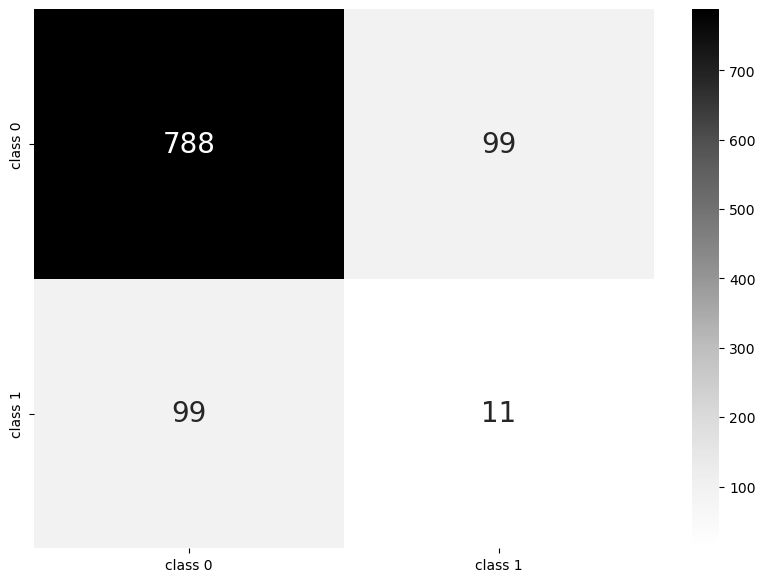

In [17]:
predictions = model.predict([ts_x, ts_x], batch_size=batch_size, verbose=0)
y_pred = predictions.argmax(axis=-1)
y_true = ts_label

# Tính toán confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

print(evaluation(y_pred, y_true))

# Vẽ confusion matrix
df_cm = pd.DataFrame(cf_matrix, index=["class 0", "class 1"],
                     columns=["class 0", "class 1"])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Greys", fmt='g', cbar=True, annot_kws={"size": 20})
plt.show()

In [18]:
max_words = 10000
max_len = 100
embedding_dim = 32

In [19]:
input_shape = (max_len,)
# Branch 1
input1 = Input(shape=input_shape)
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.3))
branch1.add(GlobalMaxPooling1D())

branch1_output = branch1(input1)

# Branch 2
input2 = Input(shape=input_shape)
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.3))
branch2.add(GlobalMaxPooling1D())

branch2_output = branch2(input2)

# Concatenate branches
concatenated = Concatenate()([branch1_output, branch2_output])

# Add hidden and output layers
hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.2)(hid_layer)
output_layer = Dense(2, activation='softmax')(dropout)

# Define the model
model = Model(inputs=[input1, input2], outputs=output_layer)

# Print model summary
model.summary()

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 64)        │    326,464 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64)        │    326,464 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ sequential_2[0][… │
│ (Concatenate)       │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        258 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 669,698 (2.55 MB)

 Trainable params: 669,442 (2.55 MB)

 Non-trainable params: 256 (1.00 KB)

In [20]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 64)        │    326,464 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64)        │    326,464 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ sequential_2[0][… │
│ (Concatenate)       │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        258 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 669,698 (2.55 MB)

 Trainable params: 669,442 (2.55 MB)

 Non-trainable params: 256 (1.00 KB)

In [21]:
model.load_weights('../models/model_cnn_ctsd.h5')